# Label propagation
Each organ expert group had used cellxgene to annotate celltypes from a cellxgene object. 
We read in the csv output by cellxgene (this required a little bit of manual engineering because the column names and numbers are not the same) 
Also skin was a last addition to the dataset, and is derived using a SS2 dataset rather than 10X, so the file names contain skin to differentiate it from previous versions of annotation.

# load necessary pacakges

In [1]:
import sys
import os 

sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('/data/yosef2/users/chenling/tabula-sapiens/')
import anndata

from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *
from anndata import read_h5ad
import scanpy as sc

from copy import deepcopy
retrain=False

import matplotlib
%matplotlib inline

# set and create directories for saving results

In [30]:
data_path = '/data/yosef2/users/chenling/TabulaSapiensData/'
model_path = '/data/yosef2/users/chenling/TabulaSapiens/scVImodels_final/'
res_path = '/data/yosef2/users/chenling/TabulaSapiens/Pilot2_rerun/'

if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(model_path+'scanvi/'):
    os.mkdir(model_path+'scanvi/')
if not os.path.exists(res_path):
    os.mkdir(res_path)

# make annotation file for pilot2
This section of the notebook summarizes and concatenate the cellxgene output csv files and generate an annotation file 'Pilot2/pilot2.all.unique.skin.csv' for all Pilot2 datasets.

In [3]:
ann_path = '/data/yosef2/users/chenling/TabulaSapiensData/Pilot2/ManualAnnotation/'
ann_files = os.listdir(ann_path)
print(ann_files)

['TSP2.lung.SoRi.csv', 'TSP2.trachea.William.csv', 'TSP2.thymus.Koki.csv', 'TSP2.bladder.Aaron.csv', 'TSP2.blood.Sheela.csv', 'TSP2.lymphnode.Kimberly.csv', 'TSP2.spleen.Kimberly.csv', 'TSP2.li.Zhen.csv', 'TSP2.muscle.Antoine.csv', 'TSP2.si.Zhen.csv', 'TSP2.skin.Kimberly.csv', 'hide', 'TSP2.vasculature.Ragini.csv', 'TSP2.kidney.Gabe.csv', 'TSP2_BM_ManualAnnotation_MSwift.h5ad', 'TSP2.all.unique.csv', 'TSP2.bm.MSwift.csv']


In [4]:
pilot2_meta = pd.read_csv(data_path + 'Pilot2/pilot2.meta.csv', index_col=0)

In [5]:
annotations = {}
for x in ann_files:
    if 'csv' in x:
        print(x)
        organ = x.split('.')[1]
        if organ=='bm':
            tab = pd.read_csv(ann_path + x, index_col=0)
        else:
            tab = pd.read_csv(ann_path + x, index_col=0, skiprows=2)
        tab.index = [x.split('-')[0] for x in tab.index]
        if organ=='muscle':
            barcodes = tab.index
            unique_barcodes, count = np.unique(barcodes, return_counts=True)
            is_unique = [x in unique_barcodes[count==1] for x in barcodes]
            tab = tab.loc[is_unique]
        is_pilot2 = [x for x in tab.index if x in pilot2_meta.index]
        tab = tab.loc[is_pilot2]        
        tab = tab[[tab.columns[-1]]]
        tab.columns= ['manual_annotation']
        tab['organ'] = organ
        print(np.unique([len(x) for x in tab.index], return_counts=True))
        annotations[organ] = tab


TSP2.lung.SoRi.csv
(array([16]), array([20605]))
TSP2.trachea.William.csv
(array([16]), array([4680]))
TSP2.thymus.Koki.csv
(array([16]), array([8035]))
TSP2.bladder.Aaron.csv
(array([16]), array([10334]))
TSP2.blood.Sheela.csv
(array([16]), array([10177]))
TSP2.lymphnode.Kimberly.csv
(array([16]), array([9110]))
TSP2.spleen.Kimberly.csv
(array([16]), array([7294]))
TSP2.li.Zhen.csv
(array([16]), array([7704]))
TSP2.muscle.Antoine.csv
(array([16]), array([15689]))
TSP2.si.Zhen.csv
(array([16]), array([6273]))
TSP2.skin.Kimberly.csv
(array([78, 79, 80, 81, 82, 83, 84, 85, 86]), array([  4,  13,  27,  56,  70, 197, 190, 153, 146]))
TSP2.vasculature.Ragini.csv
(array([16]), array([7492]))
TSP2.kidney.Gabe.csv
(array([16]), array([22403]))
TSP2.all.unique.csv
(array([16]), array([132103]))
TSP2.bm.MSwift.csv
(array([16]), array([2881]))


In [6]:
ann = pd.concat([annotations[x] for x in annotations.keys() if x != 'all'], axis=0)
print(ann.shape)
barcodes = ann.index
unique_barcodes, count = np.unique(barcodes, return_counts=True)
ann = ann.loc[unique_barcodes[count==1]]
print(ann.shape)

(133533, 2)
(132961, 2)


In [7]:
ann = pd.concat([annotations[x] for x in annotations.keys() if x != 'all'], axis=0)
print(ann.shape)
barcodes = ann.index
unique_barcodes, count = np.unique(barcodes, return_counts=True)
ann = ann.loc[unique_barcodes[count==1]]
print(ann.shape)

(133533, 2)
(132961, 2)


In [8]:
ann.to_csv(data_path + 'Pilot2/pilot2.all.unique.skin.csv')

# Combining labels and unannotated filtered object
This section of the notebook matches the annotation file to unannoated combeind object from pilot1 and pilot2.

### read unannotated combined object

In [9]:
combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.no_heart_fat_low_quality.june30.ss2_norm.embedding_donor_tech.h5ad')

### match 'Pilot1/pilot1.ann.csv' and 'Pilot2/pilot2.all.unique.skin.csv' to unannotated cells by their cell id. 

In [10]:
ann1 = pd.read_csv(data_path+'Pilot1/pilot1.ann.csv', index_col=0, dtype=str)

In [11]:
ann2 = combined.obs.loc[combined.obs['donor']=='TSP2']
ann2.index = [x.split('-')[0] for x in ann2.index]

In [12]:
unique = ann2.index.drop_duplicates(keep=False)
ann2 = ann2.loc[unique]

In [13]:
ann2_new = pd.read_csv(data_path + 'Pilot2/pilot2.all.unique.skin.csv', index_col=0, dtype=str)
ann2_new['Organ'] = [x[0].upper()+x[1:] for x in ann2_new['organ']]
ann2_new['Organ'].replace('Bm', 'Bone_Marrow', inplace=True)
ann2_new['Organ'].replace('Li', 'Large_Intestine', inplace=True)
ann2_new['Organ'].replace('Lymphnode', 'Lymph_Node', inplace=True)
ann2_new['Organ'].replace('Si','Small_Intestine', inplace=True)
ann2.index = [x+'_'+y for x,y in zip(ann2.index.values, ann2['tissue'])]
ann2_new.index = [x+'_'+y for x,y in zip(ann2_new.index.values, ann2_new['Organ'])]
ann2['manual_annotation'] = ann2_new.loc[ann2.index, 'manual_annotation']
ann2['manual_annotation'].fillna('unassigned',inplace=True)

In [14]:
ann1.index = ['_'.join(['TSP1',x]) for x in ann1.index]
ann2.index = ['_'.join(['TSP2',x,y]) for x,y in zip(ann2.index, ann2['sequencer'])]

In [15]:
idx1 = combined.obs.loc[combined.obs['donor']=='TSP1'].index
idx2 = combined.obs.loc[combined.obs['donor']=='TSP2'].index
seq2 = combined.obs.loc[combined.obs['donor']=='TSP2',['tissue','sequencer']].apply(lambda x:"_".join(x), axis=1)

idx1 = [x.split('-')[0] for x in idx1]
idx2 = [x.split('-')[0] for x in idx2]
idx1 = ['_'.join(['TSP1',x]) for x in idx1]
idx2 = ['_'.join(['TSP2',x,y]) for x,y in zip(idx2, seq2)]

assert len(idx1) == len(np.unique(idx1))
assert len(idx2) == len(np.unique(idx2))

### convert manual annotation terms to cell ontology terms using 'ontology/pilot2.manual2co.txt'

In [19]:
label_dict = pd.read_csv(data_path + 'ontology/pilot2.manual2co.txt', delimiter=';', index_col=0, dtype=str)
new_terms = pd.read_csv(data_path + 'ontology/new_terms.csv', delimiter='|', index_col=1, dtype=str)

labels1 = ann1.loc[idx1, 'Manual Annotation Round 2'].fillna('unassigned')
labels2 = ann2.loc[idx2, 'manual_annotation'].fillna('unassigned')
print(np.sum(labels1=='unassigned')/len(labels1),np.sum(labels2=='unassigned')/len(labels2))

0.4773788955013758 0.2830430395879245


In [20]:
labels = pd.concat([labels1, labels2])
labels = pd.DataFrame(labels)

In [21]:
labels_clean = []
others = []
for x in labels[0]:
    if x=='unassigned':
        labels_clean.append(x)
    elif x not in label_dict.index:
        labels_clean.append(new_terms.loc[x, 'parent_name'])
        others.append(x)
    else:
        labels_clean.append(label_dict.loc[x,'cell_ontology_class'])

labels[1] = labels_clean

In [22]:
combined.obs['barcode']=''
combined.obs.loc[combined.obs['donor']=='TSP1', 'barcode'] = idx1
combined.obs.loc[combined.obs['donor']=='TSP2', 'barcode'] = idx2

combined.obs['manual_annotation'] = labels.loc[combined.obs['barcode'],0].values
combined.obs['manual_cell_ontology_class'] = labels.loc[combined.obs['barcode'],1].values


In [23]:
temp = [x.split('_')[1] for x in combined.obs['barcode']]
assert np.sum([x in y for x,y in zip(temp, combined.obs.index)]) == len(temp)

In [24]:
combined.obs.to_csv(data_path + 'Pilot1_Pilot2.annotation.csv')

# read dataset with manual annotation

In [25]:
combined = read_h5ad(data_path + 
                     'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.ss2_norm.embedding_donor_tech.h5ad')

annotations = pd.read_csv(data_path + 'Pilot1_Pilot2.annotation.csv')

annotations.index = annotations['cell_id']

combined.obs['manual_cell_ontology_class'] = annotations.loc[combined.obs['cell_id'],'manual_cell_ontology_class'].values
combined.obs['manual_annotation'] = annotations.loc[combined.obs['cell_id'],'manual_annotation'].values
combined.obs['manual_annotation'].fillna('unassigned',inplace=True)
combined.obs['manual_cell_ontology_class'].fillna('unassigned',inplace=True)

# propagate labels per tissue

In [26]:
organs = np.unique(combined.obs['tissue'])

In [31]:
labels = pd.DataFrame(index=combined.obs.index, columns=['pred_pretrained', 'pred_subsampled'])

In [32]:
organs = [ x for x in organs if x not in ['Heart','Fat']]
print(organs)

['Bladder', 'Blood', 'Bone_Marrow', 'Kidney', 'Large_Intestine', 'Lung', 'Lymph_Node', 'Muscle', 'Pancreas', 'Skin', 'Small_Intestine', 'Spleen', 'Thymus', 'Trachea', 'Vasculature']


# train using pre-trained scVI model

Bladder


Trying to set attribute `.obs` of view, copying.


[2020-07-15 16:00:19,210] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-15 16:00:19,212] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-15 16:00:23,482] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-15 16:00:25,086] INFO - scvi.dataset.dataset | Downsampled from 25751 to 25751 cells
labelled indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
unlabelled indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18]


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14

['B cell' 'T cell' 'basal cell' 'bladder urothelial cell'
 'endothelial cell' 'fibroblast' 'intermediate epitheliocyte' 'macrophage'
 'mast cell' 'mature NK T cell' 'myoblast' 'myofibroblast cell'
 'natural killer cell' 'plasma cell' 'plasmacytoid dendritic cell, human'
 'smooth muscle cell' 'vascular associated smooth muscle cell'
 'vein endothelial cell'] ['B cell' 'T cell' 'basal cell' 'bladder urothelial cell'
 'endothelial cell' 'fibroblast' 'intermediate epitheliocyte' 'macrophage'
 'mast cell' 'mature NK T cell' 'myoblast' 'myofibroblast cell'
 'natural killer cell' 'plasma cell' 'plasmacytoid dendritic cell, human'
 'smooth muscle cell' 'unassigned'
 'vascular associated smooth muscle cell' 'vein endothelial cell']
Blood


Trying to set attribute `.obs` of view, copying.


[2020-07-15 16:10:43,362] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-15 16:10:43,366] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-15 16:10:45,777] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-15 16:10:46,926] INFO - scvi.dataset.dataset | Downsampled from 16017 to 16017 cells
labelled indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
unlabelled indices:  [ 0  1  2  3  4  5  7 12 13 14 15 17 18]


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 31.72 GiB total capacity; 1.64 GiB already allocated; 31.56 MiB free; 73.05 MiB cached)

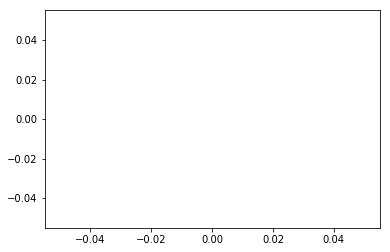

In [33]:
for organ in organs:
    print(organ)
    organ_data = combined[combined.obs['tissue']==organ]
    if organ=='Skin':
        organ_data = organ_data[organ_data.obs['method']=='smartseq2']

    train_data = scVIdata_preprocess(organ_data, 'donor_tech', 'manual_cell_ontology_class')
    posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12.all-minus-fat-heart.donor_tech.50.3.ss2_norm.scVI.pkl', 
                               retrain=retrain, n_epochs=100)

    full, pred_celltype = scanvi_pred(train_data, 
                                      model_path+'Pilot12.all-minus-fat-heart.donor_tech.50.3.ss2_norm.scVI.pkl',
                                      model_path+'combined.%s.scANVI.pretrained.pkl'%organ,
                                      nlabels=30, retrain=retrain)

    pred_celltype = np.asarray([train_data.cell_types[x] for x in pred_celltype])
    assert np.sum(pred_celltype=='unassigned')==0
    labels.loc[organ_data.obs.index,'pred_pretrained'] = pred_celltype
    print(np.unique(pred_celltype), train_data.cell_types)

# train using per-organ scVI model
We subsample genes before training scVI to predict cell types

In [ ]:
retrain=True
for organ in organs:
    print(organ)
    organ_data = combined[combined.obs['tissue']==organ]
    if organ=='Skin':
        organ_data = organ_data[organ_data.obs['method']=='smartseq2']
    organ_data = organ_data[organ_data.obs['manual_cell_ontology_class']!='low_quality']
    sc.pp.filter_genes(organ_data, min_cells=1)
    train_data = scVIdata_preprocess(organ_data, 'donor_tech', 'manual_cell_ontology_class')
    train_data.filter_genes_by_count(per_batch=True)
    if train_data.X.shape[0]>10000:
        train_data.subsample_genes(train_data.X.shape[0]//5)
    else:
        train_data.subsample_genes(train_data.X.shape[0]//2)
    posterior = get_scvi_posterior(train_data, 
                               model_path+'combined.%s.scVI.subsample_genes.pkl'%organ, 
                               retrain=retrain, n_epochs=100)


    full, pred_celltype = scanvi_pred(train_data, 
                                      model_path+'combined.%s.scVI.subsample_genes.pkl'%organ,
                                      model_path+'combined.%s.scANVI.subsample_genes.pkl'%organ,
                                      nlabels=30, retrain=retrain)

    pred_celltype = np.asarray([train_data.cell_types[x] for x in pred_celltype])
    assert np.sum(pred_celltype=='unassigned')==0
    labels.loc[organ_data.obs.index,'pred'] = pred_celltype
    print(np.unique(pred_celltype), train_data.cell_types)

In [ ]:
labels['pred'].fillna('unassigned', inplace=True)

In [ ]:
np.unique(combined.obs.loc[labels['pred']=='unassigned','tissue'])

In [ ]:
np.sum(labels['pred']=='unassigned')

In [ ]:
np.sum([x == 'low_quality' for x in combined.obs['manual_cell_ontology_class']])

In [ ]:
np.sum([x in ['Fat', 'Heart', "Skin"] for x in combined.obs['tissue']])

In [ ]:
combined.obs['propagated_cell_ontology_class'] = labels.loc[combined.obs.index, 'pred']

In [ ]:
combined.write_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.ss2_norm.embedding_donor_tech.propagated.subsample_genes.h5ad')

In [ ]:
combined.obs.to_csv(data_path + 'combined/annotation.subsample_genes.csv')